Importation des packages

In [64]:
import pandas as pd
import numpy as np
import itertools
import sklearn
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import missingno as msno
import seaborn as sns

Importation des données

In [65]:
df_gono = pd.read_csv("gono.csv", sep=',')
df_gono.head()

,ID,SEXE,ETAT_C,AGE,ORIENT_SEX,MTS_ANT,NB_MTS,RAISON,NB_PART,HISTOIRE,CULTURE,DIAGN
0,1002,1,1,29,1,2,8,3,5.0,0.0,0.0,0.0
1,1010,1,1,18,1,1,0,2,1.0,1.0,1.0,1.0
2,1011,1,1,24,1,2,1,1,2.0,0.0,0.0,0.0
3,1012,1,1,29,1,2,3,1,6.0,0.0,1.0,1.0
4,1013,1,3,28,1,2,3,1,2.0,0.0,0.0,0.0


Traitement de données

In [42]:
df_gono.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          3144 non-null   int64  
 1   SEXE        3144 non-null   int64  
 2   ETAT_C      3144 non-null   int64  
 3   AGE         3144 non-null   int64  
 4   ORIENT_SEX  3144 non-null   int64  
 5   MTS_ANT     3144 non-null   int64  
 6   NB_MTS      3144 non-null   int64  
 7   RAISON      3144 non-null   int64  
 8   NB_PART     3143 non-null   float64
 9   HISTOIRE    3143 non-null   float64
 10  CULTURE     3143 non-null   float64
 11  DIAGN       3143 non-null   float64
dtypes: float64(4), int64(8)
memory usage: 294.9 KB


In [62]:

# Liste des colonnes à convertir en type objet
colonnes_a_convertir = ['DIAGN', 'CULTURE', 'HISTOIRE', 'MTS_ANT', 'RAISON', 'ORIENT_SEX', 'ETAT_C', 'SEXE']

# Conversion des types de données
for colonne in colonnes_a_convertir:
    if colonne in df_gono.columns:
        df_gono[colonne] = df_gono[colonne].astype(str)

# Vérification des changements
df_gono.dtypes


,0
ID,int64
SEXE,object
ETAT_C,object
AGE,int64
ORIENT_SEX,object
MTS_ANT,object
NB_MTS,int64
RAISON,object
NB_PART,float64
HISTOIRE,object


In [66]:
#Compter et afficher les valeurs manquantes par variables
df_gono.isnull().sum()

,0
ID,0
SEXE,0
ETAT_C,0
AGE,0
ORIENT_SEX,0
MTS_ANT,0
NB_MTS,0
RAISON,0
NB_PART,1
HISTOIRE,1


In [ ]:
df_gono.shape

(3144, 12)

In [44]:
df_gono[['AGE','NB_PART', 'NB_MTS']].describe()

,AGE,NB_PART,NB_MTS
count,3144.000000,3143.000000,3144.000000
mean,28.583333,5.207127,1.209924
std,8.405454,15.020272,2.563570
min,14.000000,0.000000,0.000000
25%,23.000000,1.000000,0.000000
50%,27.000000,2.000000,1.000000
75%,33.000000,3.000000,1.000000
max,99.000000,99.000000,65.000000


Nous avons 3144 observations et 12 variables.

Traitement des données manquantes

In [67]:
# Remplacer 99 avec NaN pour 'Age' et 'Nombre de partenaire'
df_gono['AGE'] = df_gono['AGE'].replace(99, np.nan)
df_gono['NB_PART'] = df_gono['NB_PART'].replace(99, np.nan)

# Remplacer 9 avec NaN pour les autres colonne excepte 'Nombres de MTS', 'sexe', and 'identification'
for col in df_gono.columns:
    if col not in ['AGE', 'NB_PART', 'NB_MTS', 'SEXE', 'ID']:
        df_gono[col] = df_gono[col].replace(9, np.nan)

df_gono.isnull().sum()


,0
ID,0
SEXE,0
ETAT_C,4
AGE,6
ORIENT_SEX,257
MTS_ANT,0
NB_MTS,0
RAISON,2
NB_PART,66
HISTOIRE,107


Ce graphique permet de visualiser les variables avec les valeurs manquantes.

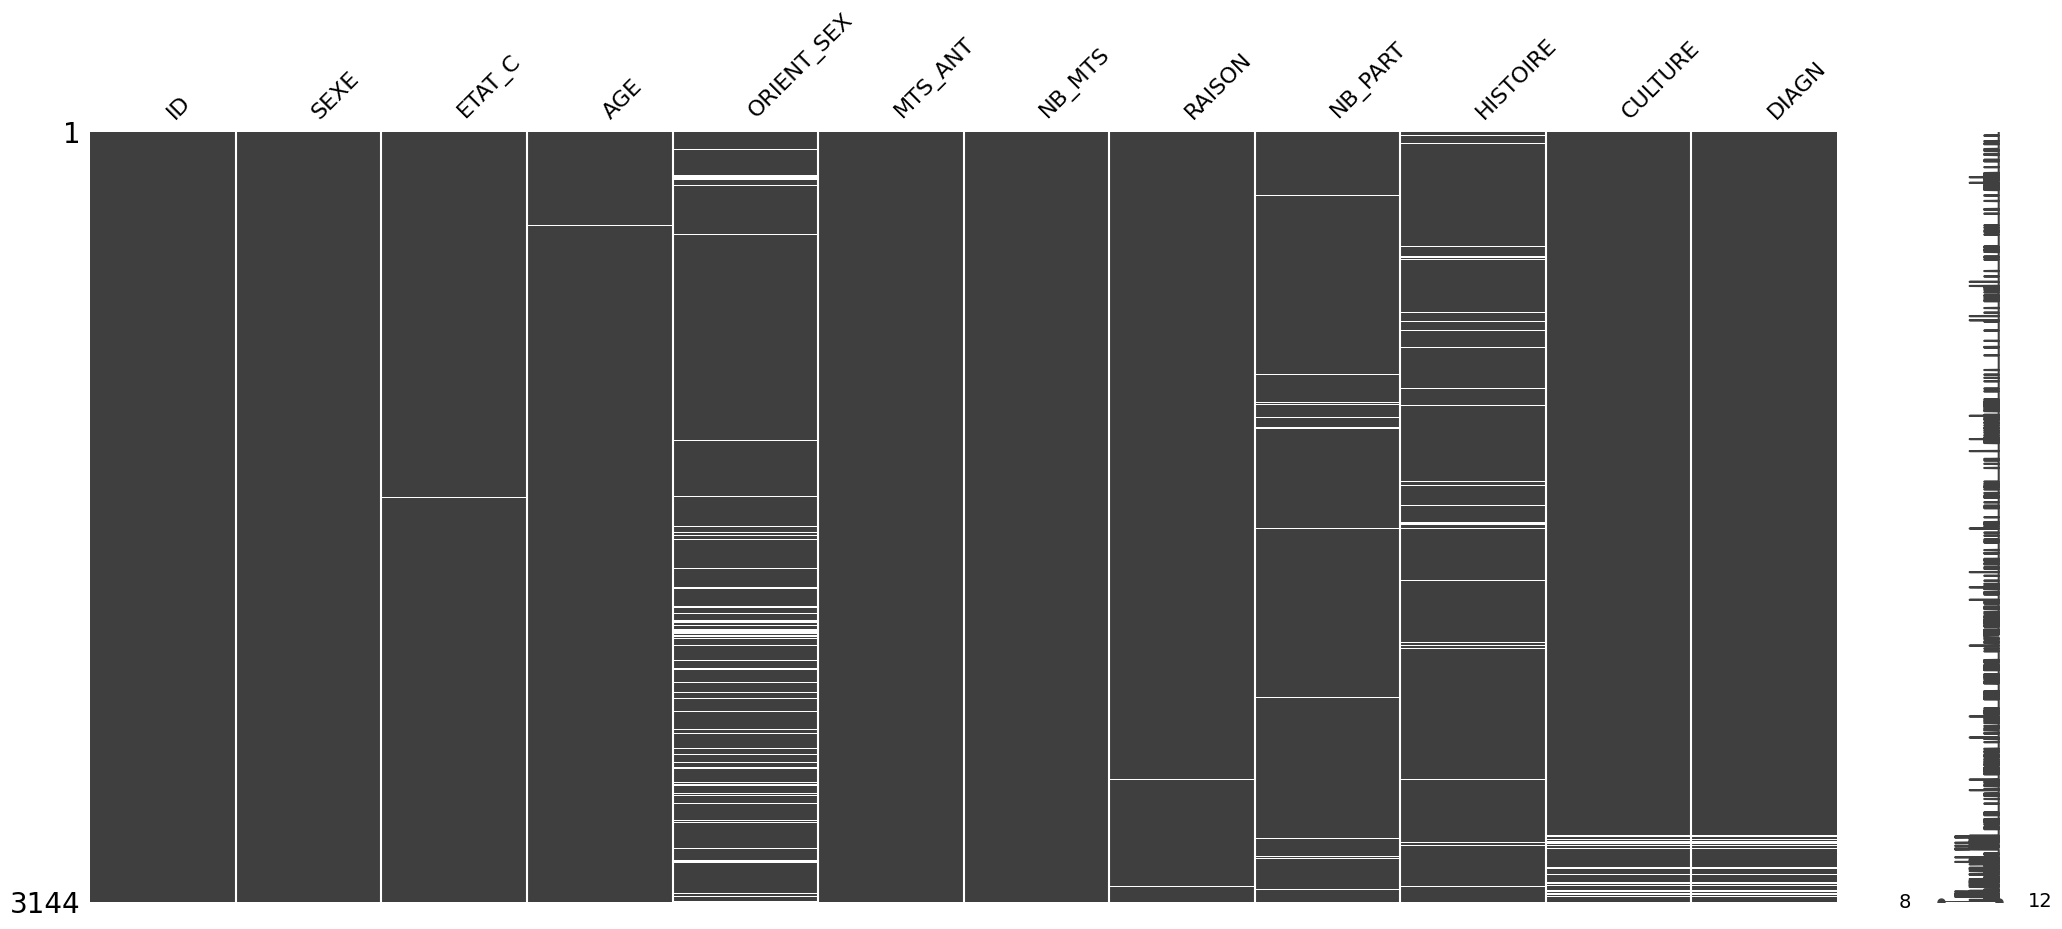

In [46]:
msno.matrix(df_gono)
plt.show()

Matrice de correlation pour voir la relation entre les valeurs manquantes.

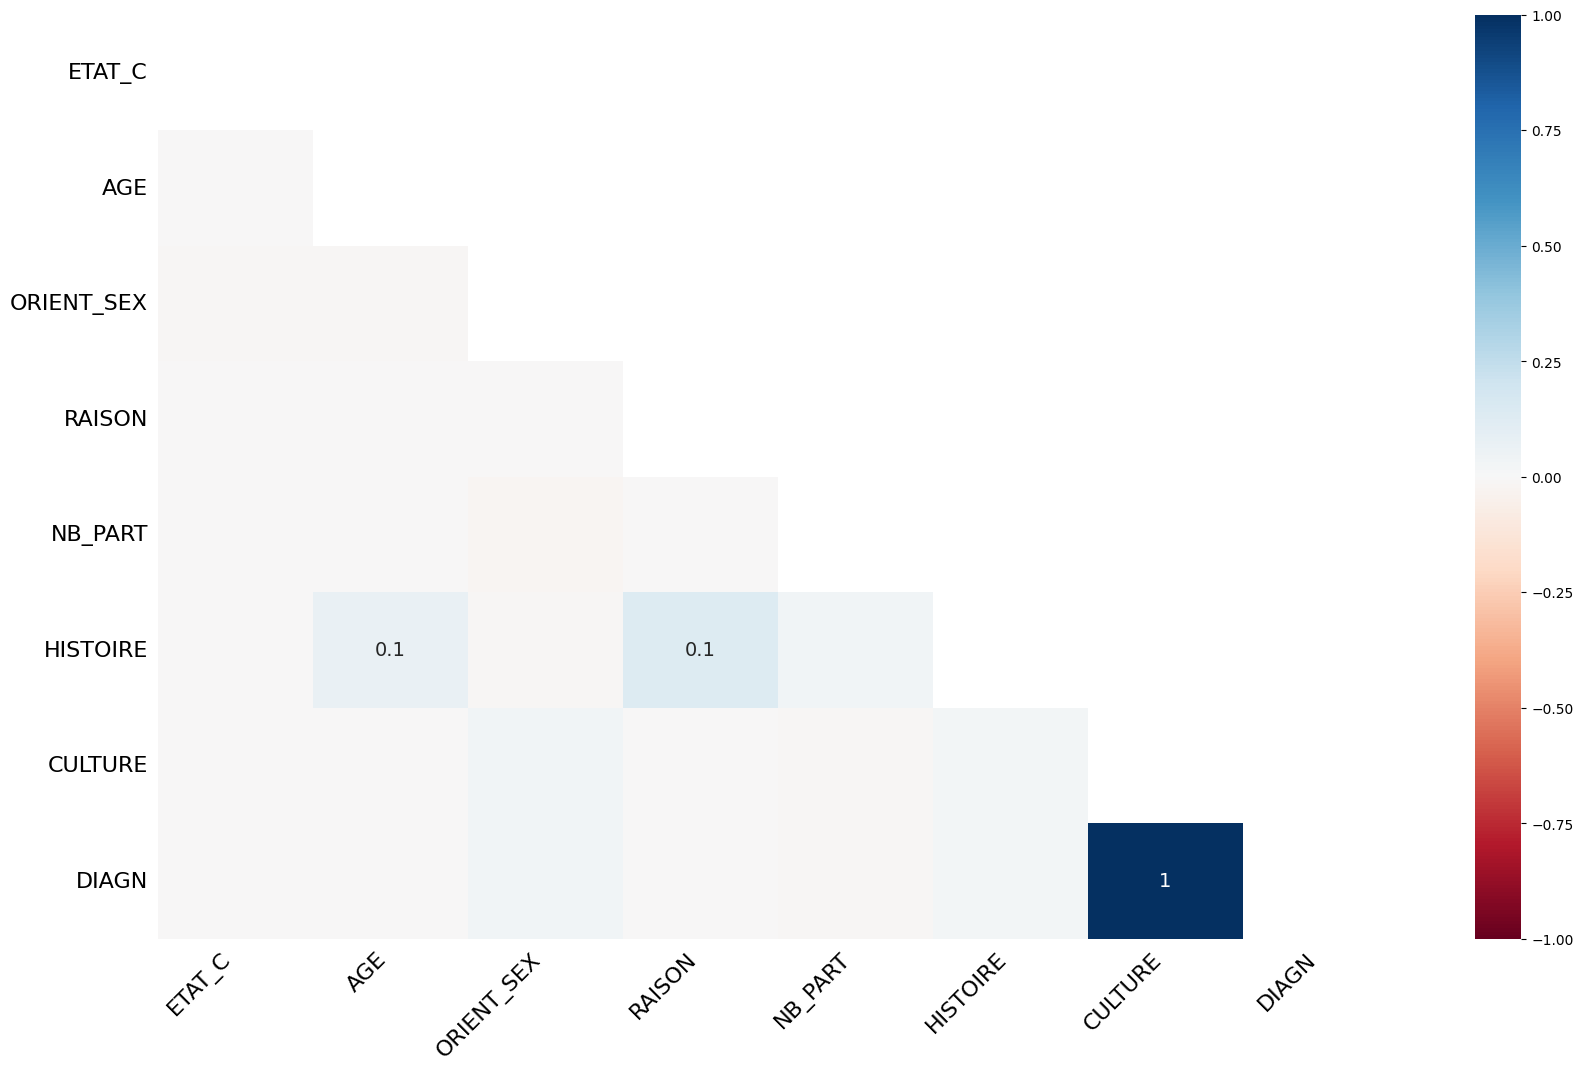

In [ ]:
msno.heatmap(df_gono)
plt.show()

In [ ]:
#Repartition des valeurs manquantes par pourcentage
missing_values =df_gono.isnull().sum()
missing_percent =(missing_values/ len(df_gono)) * 100
missing_table =pd.DataFrame({'Missing Values': missing_values, 'Missing Percent': missing_percent})
missing_table


,Missing Values,Missing Percent
ID,0,0.000000
SEXE,0,0.000000
ETAT_C,4,0.127226
AGE,6,0.190840
ORIENT_SEX,257,8.174300
MTS_ANT,0,0.000000
NB_MTS,0,0.000000
RAISON,2,0.063613
NB_PART,66,2.099237
HISTOIRE,107,3.403308


On observe que le pourcentage des valeurs manquantes n'est pas très élevé dans certaines variables, assez considérables dans certaines variables et très faibles dans d'autres. On décide de supprimer les valeurs manquantes pour les variables **ETAT_C** (état civil), **AGE**(âge) et **RAISON**(raison), et de les imputer par le mode pour les autres variables.

In [69]:

# Supprimer les valeurs manques pour les variables AGE, ETAT_C, RAISON
df_gono = df_gono.dropna(subset=['AGE','ETAT_C','RAISON'])

# Remplacer les valeurs manquantes dans 'ORIENT_SEX' par une troisième catégorie (3)
df_gono['ORIENT_SEX'] = df_gono['ORIENT_SEX'].fillna(3)

# Remplacer les valeurs manquantes avec la valeur la plus fréquentes pour chaque colonne exceptée 'AGE', 'ETAT_C', 'RAISON'
for col in df_gono.columns:
    if col not in ['AGE', 'ETAT_C', 'RAISON', 'ORIENT', 'ORIENT_SEX']:
        # Trouver la modalité la plus fréquente
        valeur_frequente= df_gono[col].mode()[0]
        df_gono[col] = df_gono[col].fillna(valeur_frequente)
df_gono.isnull().sum()


,0
ID,0
SEXE,0
ETAT_C,0
AGE,0
ORIENT_SEX,0
MTS_ANT,0
NB_MTS,0
RAISON,0
NB_PART,0
HISTOIRE,0


On observe les statistiques des variables numériques.

In [ ]:
df_gono[['AGE','NB_PART', 'NB_MTS']].describe()

,AGE,NB_PART,NB_MTS
count,3132.000000,3132.000000,3132.000000
mean,28.451149,3.184227,1.212005
std,7.828437,6.324927,2.566971
min,14.000000,0.000000,0.000000
25%,23.000000,1.000000,0.000000
50%,27.000000,2.000000,1.000000
75%,32.000000,3.000000,1.000000
max,78.000000,98.000000,65.000000


La moyenne d'âge est de 28 ans, d'antécédent de MTS est 1 et du nombre de partenaire est de 3 pour la population d'étude.

Etude Analytique

On fait des graphiques et des tableaux croisés afin de voir la relation entre certaines variables et la variable diagnostique.

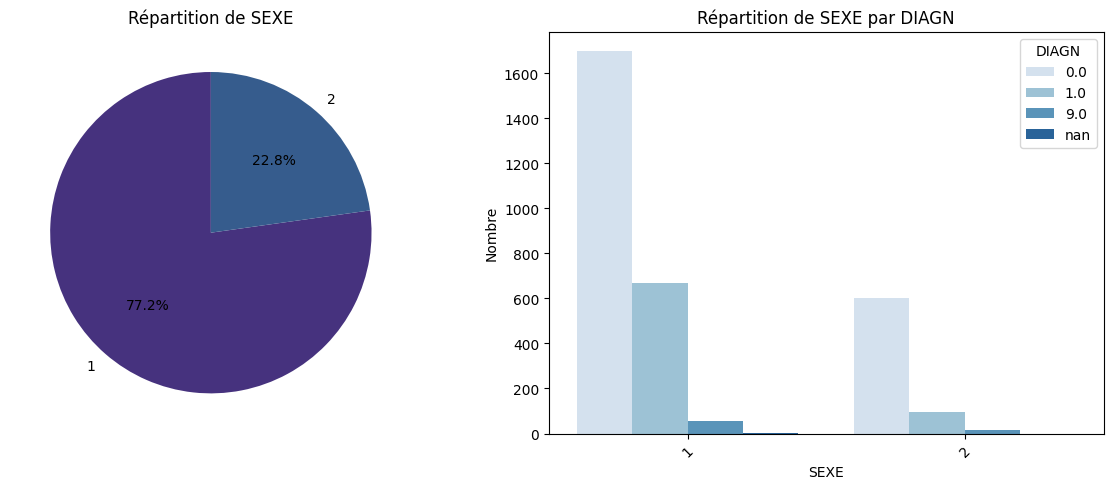

<Figure size 640x480 with 0 Axes>

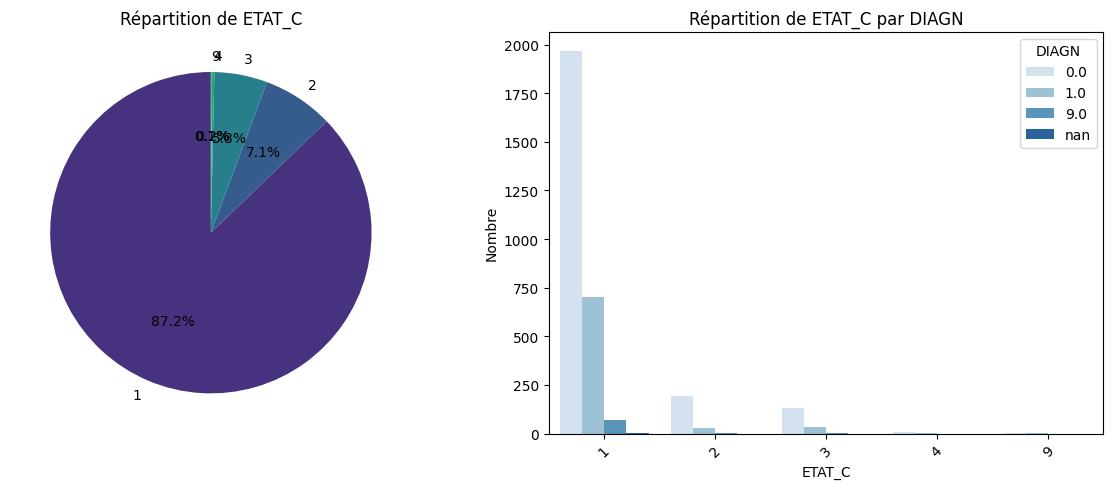

<Figure size 640x480 with 0 Axes>

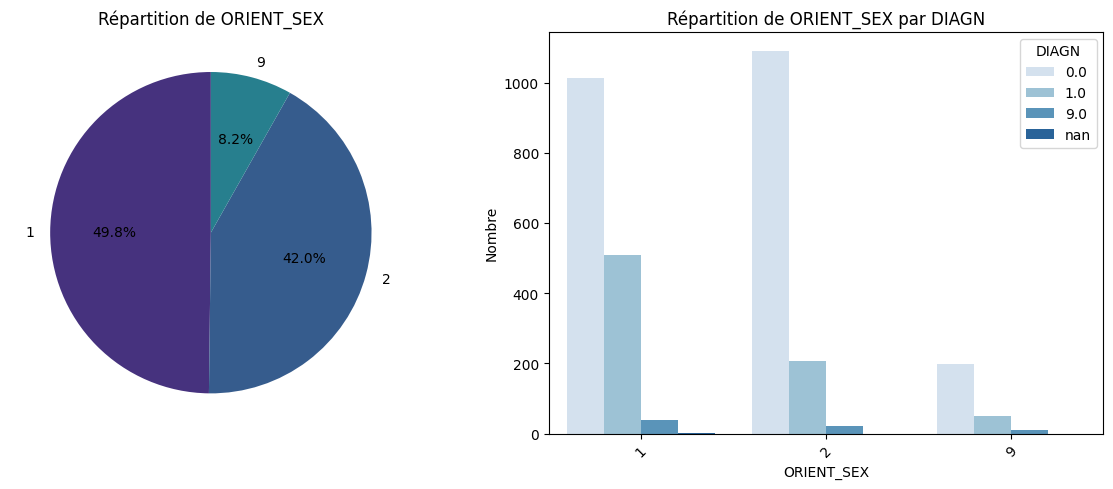

<Figure size 640x480 with 0 Axes>

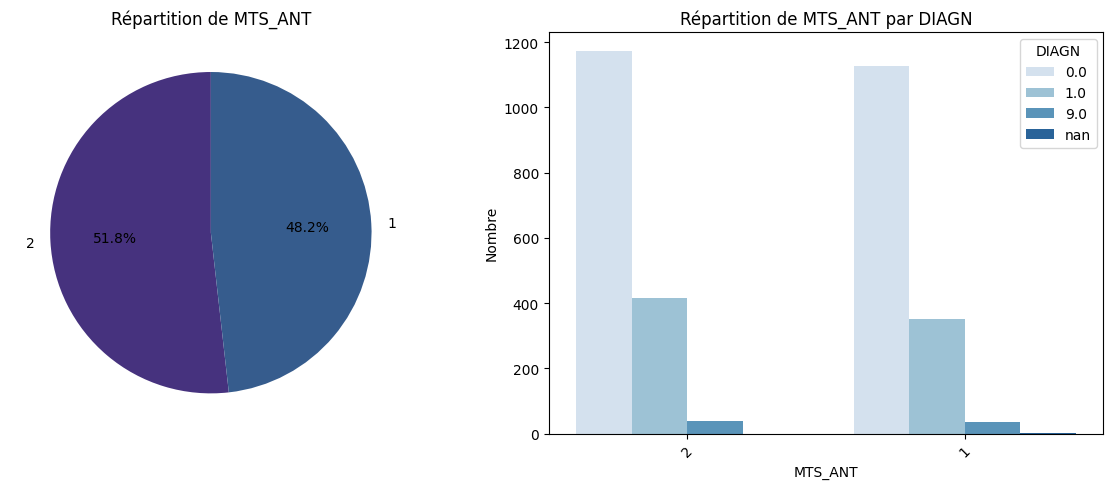

<Figure size 640x480 with 0 Axes>

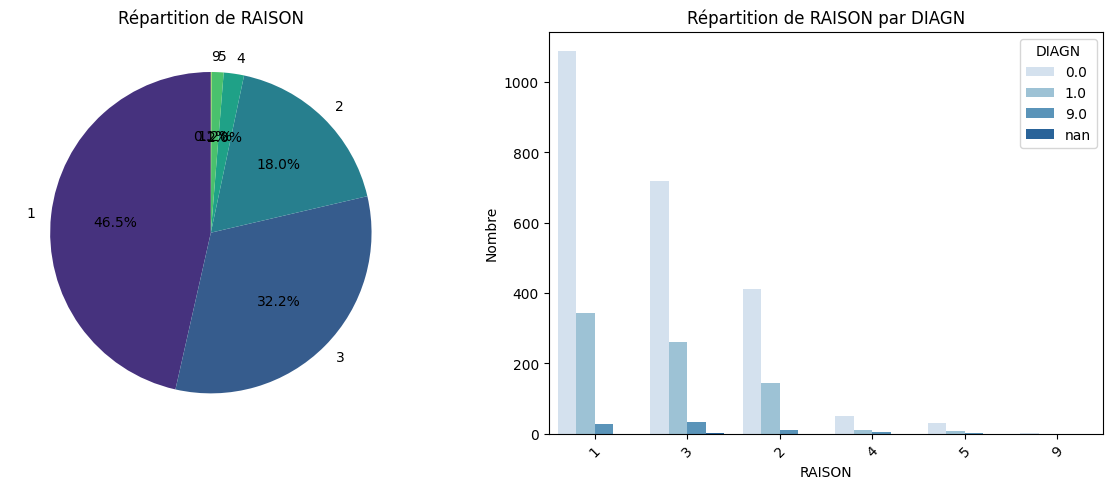

<Figure size 640x480 with 0 Axes>

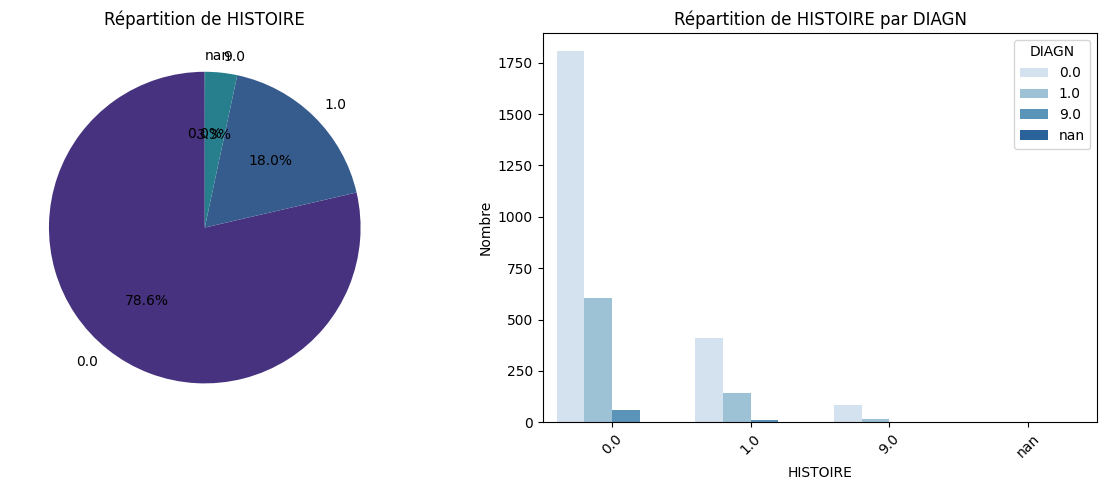

<Figure size 640x480 with 0 Axes>

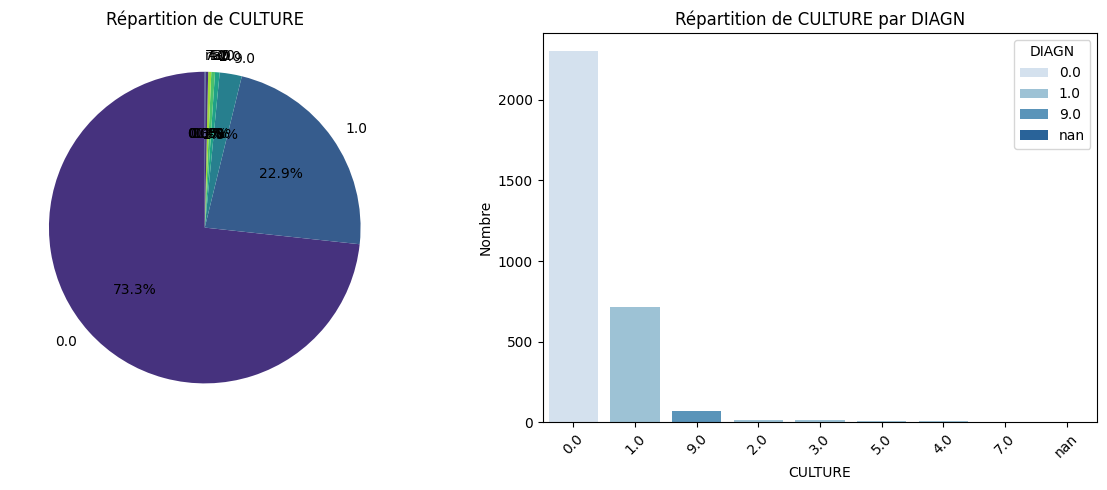

<Figure size 640x480 with 0 Axes>

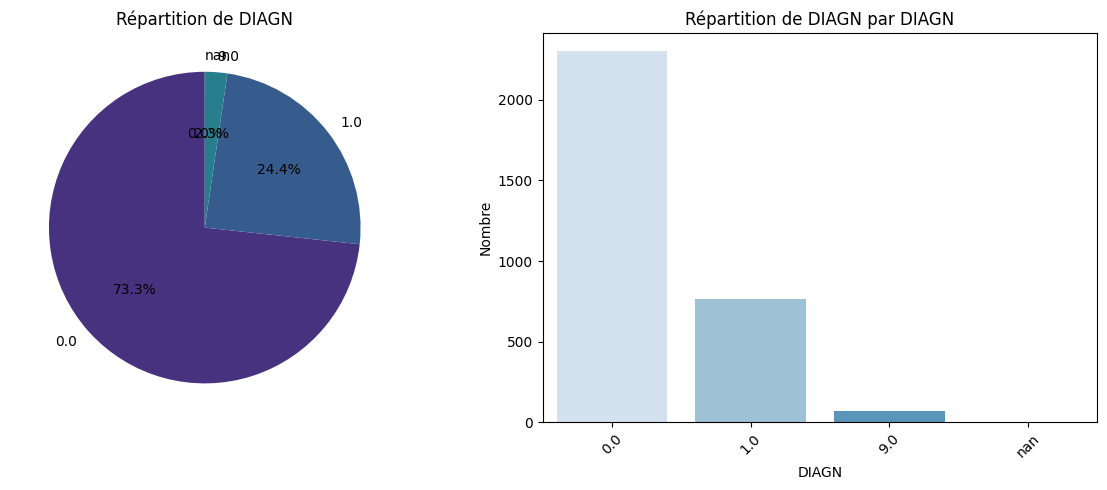

<Figure size 640x480 with 0 Axes>

In [ ]:
# Identifier les colonnes qualitatives
qualitative_cols = df_gono.select_dtypes(include=['object'])

for col in qualitative_cols:
    value_counts = df_gono[col].value_counts()
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Graphe en secteurs
    colors = sns.color_palette("pastel", len(value_counts))
    axes[0].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
    axes[0].set_title(f'Répartition de {col}')

    # Graphe en barres
    sns.countplot(data=df_gono, x=col, hue='DIAGN', palette='Blues', order=value_counts.index, ax=axes[1])
    axes[1].set_title(f'Répartition de {col} par DIAGN') # Changed this line to include 'DIAGN' in single quotes
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Nombre')
    axes[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"repartition_{col}.pdf", format='pdf')

<Axes: xlabel='AGE', ylabel='Count'>

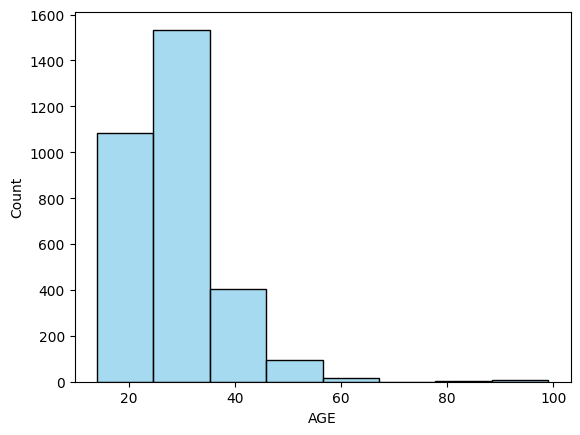

In [ ]:
#La distribution
sns.histplot(df_gono['AGE'], color ='skyblue', bins=8, kde =False)

<Axes: xlabel='NB_MTS', ylabel='Count'>

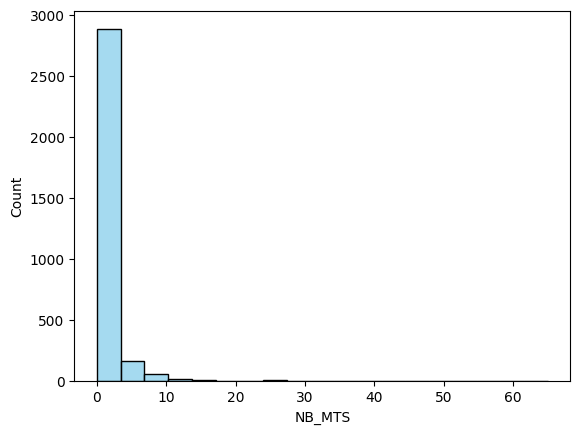

In [ ]:
sns.histplot(df_gono['NB_MTS'],color = 'skyblue', bins=19, kde=False)

<Axes: xlabel='NB_PART', ylabel='Count'>

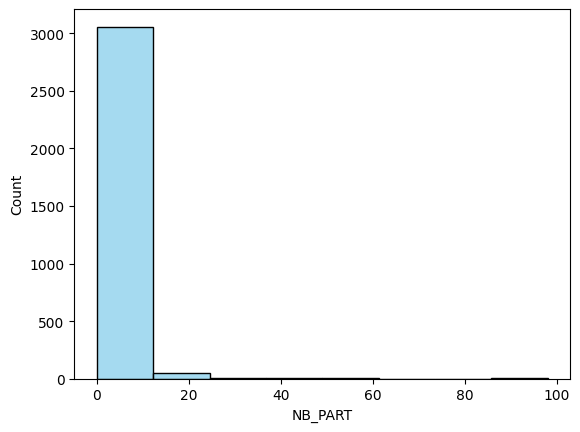

In [ ]:

sns.histplot(df_gono['NB_PART'],color = 'skyblue', bins=8, kde=False)

In [ ]:
# Identifier les colonnes qualitatives dans l'échantillon équilibré
qualitative_cols = df_gono.select_dtypes(include=['object', 'category']).columns

for col in qualitative_cols:
    if col not in ['ID', 'IDENTIFICATION']:  # Exclure les colonnes d'identification
        value_counts = df_gono[col].value_counts()
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Graphe en secteurs
        axes[0].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%',
                   startangle=90, colors=sns.color_palette('Blues_r', len(value_counts)))
        axes[0].set_title(f'Répartition de {col}')

        # Graphe en barres
        sns.countplot(data=df_gono, x=col, hue='DIAGN',
                     palette=['#386E99', '#D14124'], order=value_counts.index, ax=axes[1])
        axes[1].set_title(f'Répartition de {col} par diagnostic')
        axes[1].set_xlabel(col)
        axes[1].set_ylabel('Nombre de patients')
        axes[1].tick_params(axis='x', rotation=45)

        # Ajouter une légende plus claire
        handles, labels = axes[1].get_legend_handles_labels()
        axes[1].legend(handles, ['Négatif (0)', 'Positif (1)'], title='Diagnostic')

        plt.tight_layout()


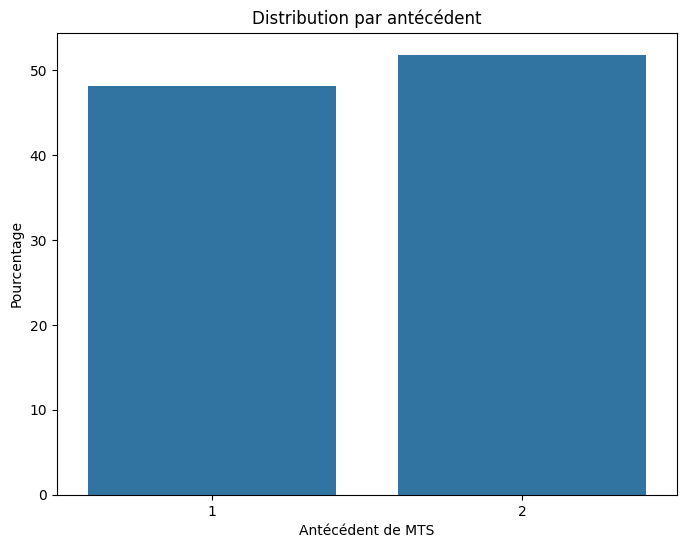

In [ ]:
# Calculer le pourcentage de la distribution par sexe
orientation_counts = df_gono['MTS_ANT'].value_counts(normalize=True) * 100

# Crée le graphique
plt.figure(figsize=(8, 6))
sns.barplot(x=orientation_counts.index, y=orientation_counts.values)
plt.xlabel("Antécédent de MTS")
plt.ylabel("Pourcentage")
plt.title("Distribution par antécédent")
plt.show()

Repartion des sexes par pourcentage

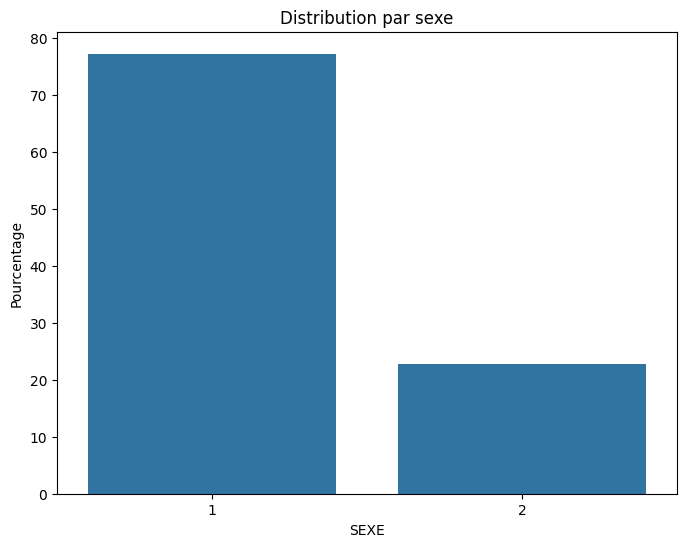

In [ ]:
# Calculer le pourcentage de la distribution par sexe
orientation_counts = df_gono['SEXE'].value_counts(normalize=True) * 100

# Crée le graphique
plt.figure(figsize=(8, 6))
sns.barplot(x=orientation_counts.index, y=orientation_counts.values)
plt.xlabel("SEXE")
plt.ylabel("Pourcentage")
plt.title("Distribution par sexe")
plt.show()

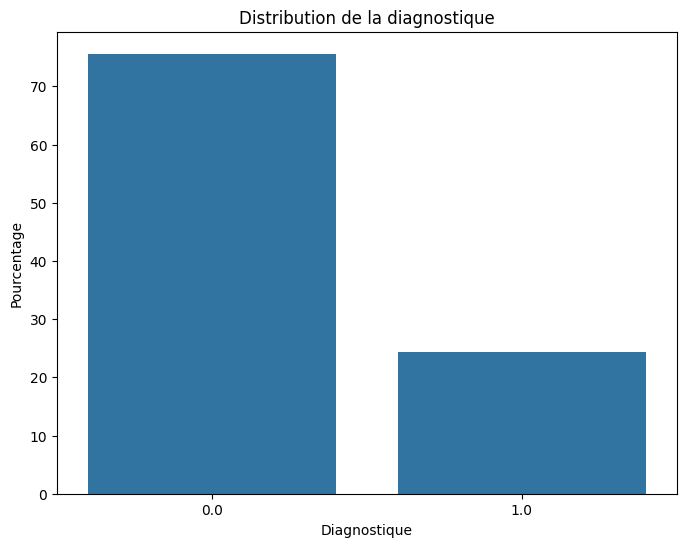

In [ ]:
# Calculer le pourcentage de la distribution de la diagnostique
orientation_counts = df_gono['DIAGN'].value_counts(normalize=True) * 100

# Crée le graphique
plt.figure(figsize=(8, 6))
sns.barplot(x=orientation_counts.index, y=orientation_counts.values)
plt.xlabel("Diagnostique")
plt.ylabel("Pourcentage")
plt.title("Distribution de la diagnostique")
plt.show()

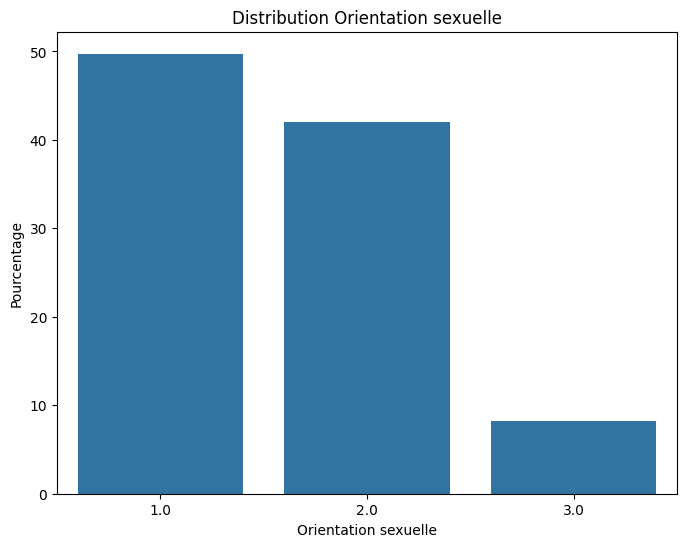

In [ ]:

# Calculer le pourcentage  de distribution
orientation_counts = df_gono['ORIENT_SEX'].value_counts(normalize=True) * 100

#
plt.figure(figsize=(8, 6))
sns.barplot(x=orientation_counts.index, y=orientation_counts.values)
plt.xlabel("Orientation sexuelle")
plt.ylabel("Pourcentage")
plt.title("Distribution Orientation sexuelle")
plt.show()


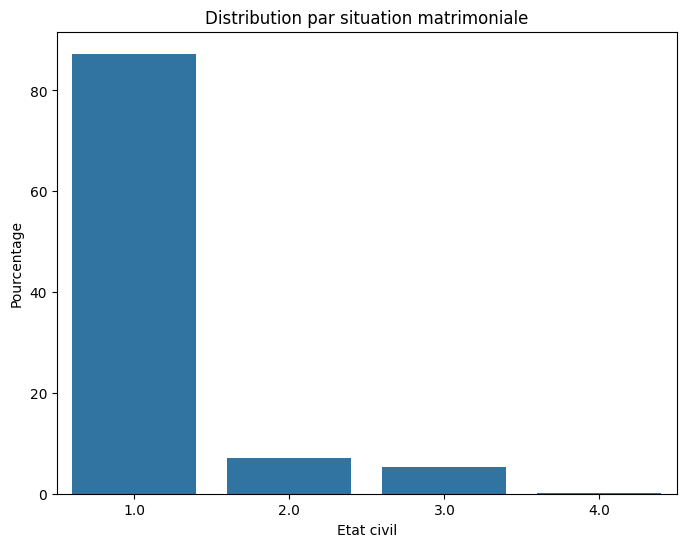

In [ ]:
# Calculer le pourcentage  de distribution
orientation_counts = df_gono['ETAT_C'].value_counts(normalize=True) * 100

#
plt.figure(figsize=(8, 6))
sns.barplot(x=orientation_counts.index, y=orientation_counts.values)
plt.xlabel("Etat civil")
plt.ylabel("Pourcentage")
plt.title("Distribution par situation matrimoniale")
plt.show()

Relation orientation sexuelle et diagnostique

<Axes: xlabel='DIAGN', ylabel='percentage'>

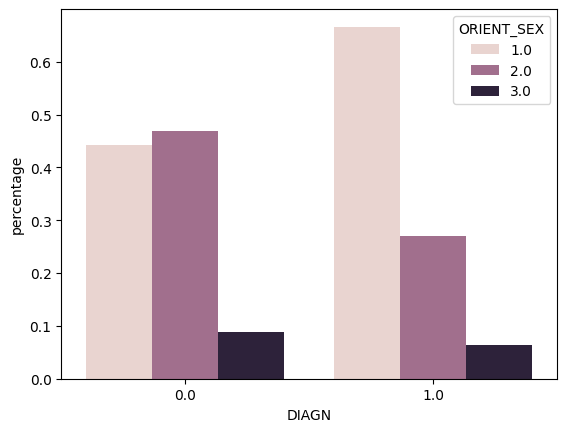

In [ ]:
import seaborn as sns
# Creation des graphiques
pourcentage_distribution = df_gono.groupby('DIAGN')['ORIENT_SEX'].value_counts(normalize=True).rename('percentage').reset_index()
sns.barplot(x='DIAGN', y='percentage', hue='ORIENT_SEX', data=pourcentage_distribution)


On observe que dans le groupe de ceux qui ont un Diagnostique pas de gonorrhée(0), il y a plus d'homosexuel et pareil dans le groupe de gonorrhée mais par contre il y a un pourcentage assez faible d'hétérosexuel.

Relation Sexe et Diagn

In [ ]:
# prompt: Comment intégrer cette fonction  plt.savefig("mon_graphique.pdf", format='pdf')

# ... (your existing code)

# Example usage within your existing loops or at the end of your script:
plt.savefig("mon_graphique.pdf", format='pdf')
plt.close() # This is important to release the figure and prevent potential memory issues when generating multiple plots.


# Example of integration into one of your existing loops:
for col in qualitative_cols:
    if col not in ['ID', 'IDENTIFICATION']:
        # ... (your existing code for creating the plot)
        plt.tight_layout()
        plt.savefig(f"repartition_{col}.pdf", format='pdf') # Save the figure to a file with a unique name
        plt.close() # Close the plot to free resources


<Axes: xlabel='DIAGN', ylabel='percentage'>

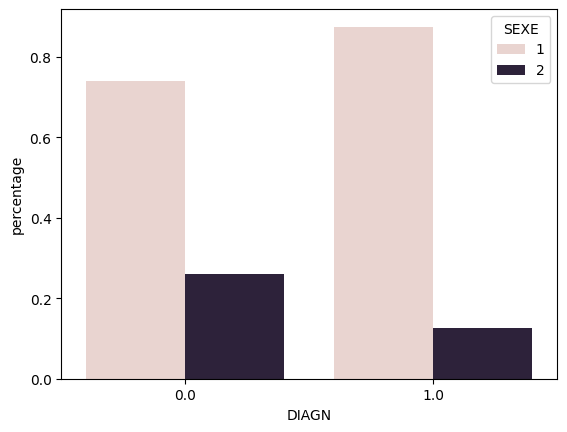

In [ ]:
# Create the plot
percentage_distribution = df_gono.groupby('DIAGN')['SEXE'].value_counts(normalize=True).rename('percentage').reset_index()
sns.barplot(x='DIAGN', y='percentage', hue='SEXE', data=percentage_distribution)


On observe que dans le groupe de ceux qui ont été diagnostiqué pas gonorrhée, il y a beaucoup d'homme et peu de femme, pareil dans le groupe de ceux qui ont été diagnostiqués gonorrhée mais très peu de femme, donc ça veux dire qu'il y a plus d'homme qui ont été diagnostiqués gonorrhée.

Relation état civil et diagnostique

<Axes: xlabel='DIAGN', ylabel='percentage'>

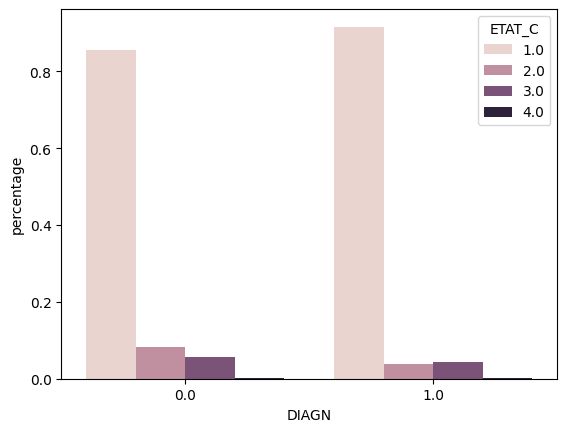

In [58]:
# Creation des graphiques
pourcentage_distribution = df_gono.groupby('DIAGN')['ETAT_C'].value_counts(normalize=True).rename('percentage').reset_index()
sns.barplot(x='DIAGN', y='percentage', hue='ETAT_C', data=pourcentage_distribution)


Relation entre l'histoire de contact et la diagnostique.

<Axes: xlabel='DIAGN', ylabel='pourcentage'>

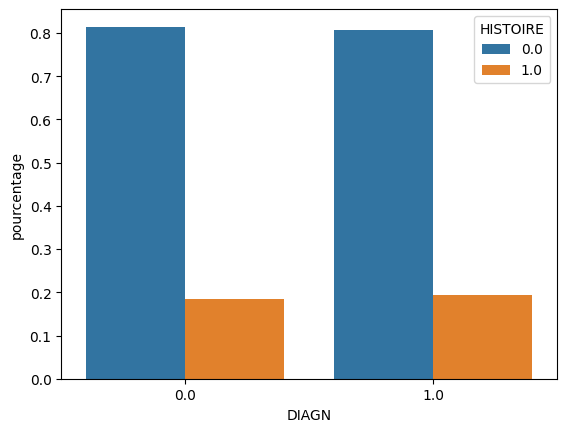

In [57]:
# Création de graphique
pourcentage_distribution = df_gono.groupby('DIAGN')['HISTOIRE'].value_counts(normalize=True).rename('pourcentage').reset_index()
sns.barplot(x='DIAGN', y='pourcentage', hue='HISTOIRE', data=pourcentage_distribution)

In [ ]:
# Pour les variables qualitatives
def plot_categorical_distributions(df_gono, exclude_columns=[]):
    for col in df_gono.select_dtypes(include='object').columns:
        if col in exclude_columns: continue
        vc = df_gono[col].value_counts()
        pct = vc / vc.sum() * 100
        print(f"\nDistribution pour '{col}':\n", pd.DataFrame({'Effectif': vc, 'Pourcentage (en %)': pct.round(2)}))
        sns.barplot(x=vc.index, y=vc.values, color="#386E99")
        for bar, label in zip(plt.gca().patches, [f"{v} ({p:.0f}%)" for v, p in zip(vc, pct)]):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label, ha='center', va='bottom', fontsize=8)
        plt.title(f'{col}'), plt.xticks(rotation=90), plt.show()

plot_categorical_distributions(df_gono, exclude_columns=["AGE", "MTS_ANT",'NB'])

Catégorisation des variables numériques

In [70]:
# Catégoriser l'âge
df_gono["AGE_GROUP"] = df_gono["AGE"].apply(lambda x: "<30" if x < 30 else ">=30")

# Catégoriser le nombre de MTS antérieures
df_gono["MTS_ANT_GROUP"] = df_gono["NB_MTS"].apply(lambda x: "Pas encore" if x == 0 else "Déjà")

# Catégoriser le nombre de partenaires
df_gono["PARTNER_GROUP"] = df_gono["NB_PART"].apply(lambda x: "Peu actifs" if x <= 3 else "Très actifs")

In [48]:
df_gono.head(10)

,ID,SEXE,ETAT_C,AGE,ORIENT_SEX,MTS_ANT,NB_MTS,RAISON,NB_PART,HISTOIRE,CULTURE,DIAGN,AGE_GROUP,MTS_ANT_GROUP,PARTNER_GROUP
0,1002,1,1.0,29.0,1.0,2,8,3.0,5.0,0.0,0.0,0.0,<30,Déjà,Très actifs
1,1010,1,1.0,18.0,1.0,1,0,2.0,1.0,1.0,1.0,1.0,<30,Pas encore,Peu actifs
2,1011,1,1.0,24.0,1.0,2,1,1.0,2.0,0.0,0.0,0.0,<30,Déjà,Peu actifs
3,1012,1,1.0,29.0,1.0,2,3,1.0,6.0,0.0,1.0,1.0,<30,Déjà,Très actifs
4,1013,1,3.0,28.0,1.0,2,3,1.0,2.0,0.0,0.0,0.0,<30,Déjà,Peu actifs
5,1014,1,1.0,40.0,1.0,2,1,1.0,4.0,0.0,0.0,0.0,>=30,Déjà,Très actifs
6,1016,1,1.0,34.0,1.0,2,5,1.0,1.0,0.0,0.0,0.0,>=30,Déjà,Peu actifs
7,1017,1,1.0,21.0,1.0,2,2,1.0,3.0,0.0,0.0,0.0,<30,Déjà,Peu actifs
8,1018,1,1.0,54.0,1.0,2,1,1.0,1.0,0.0,0.0,0.0,>=30,Déjà,Peu actifs
9,1019,1,1.0,23.0,1.0,2,2,1.0,3.0,0.0,0.0,0.0,<30,Déjà,Peu actifs


Suppression des variables numériques qui ont été catégorisées

In [71]:
df_gono=df_gono.drop(columns=['AGE','NB_MTS','NB_PART'])


Tableau croisé par Group d'Âge

In [72]:

table_age = pd.crosstab(df_gono['AGE_GROUP'], df_gono['DIAGN'], margins=True)

# Ajouter une colonne de prévalence
table_age['Prévalence (%)'] = (table_age[1.0] / table_age['All'] * 100).round(2)

print(table_age)


DIAGN       0.0  1.0   All  Prévalence (%)
AGE_GROUP                                 
<30        1437  512  1949           26.27
>=30        931  252  1183           21.30
All        2368  764  3132           24.39


La probilité d'être diagnostiqué gonorrhé est de 26,24% pour les individus de moins de 30 ans et 21,27% pour les individus de plus de 30 ans.


Tableau croisé par Activité sexuelle

In [ ]:
table_activite = pd.crosstab(df_gono['PARTNER_GROUP'], df_gono['DIAGN'], margins=True)
table_activite['Prévalence (%)'] = (table_activite[1] / table_activite['All'] * 100).round(2)

print(table_activite)


DIAGN           0.0  1.0   All  Prévalence (%)
PARTNER_GROUP                                 
Peu actifs     1974  531  2505           21.20
Très actifs     394  233   627           37.16
All            2368  764  3132           24.39


Les individus très actifs ont 32,88% et les individus Peu actifs ont 19,35% de de probilité d'être diagnostiqués gonorrhée.

Tableau croisé par Antécédent de MTS

In [ ]:
table_mts = pd.crosstab(df_gono['MTS_ANT'], df_gono['DIAGN'], margins=True)
table_mts['Prévalence (%)'] = (table_mts[1.0] / table_mts['All'] * 100).round(2)

print(table_mts)


DIAGN     0.0  1.0   All  Prévalence (%)
MTS_ANT                                 
1        1159  349  1508           23.14
2        1209  415  1624           25.55
All      2368  764  3132           24.39


Les individus ayant un antécédent de MTS ont 25,51% et ceux n'ayant pas un antécédent ont 23,14% de probabilité d'être diagnostiqués gonorrhée.

In [ ]:
table_2d = pd.crosstab(
    [df_gono['AGE_GROUP'], df_gono['PARTNER_GROUP']],
    df_gono['DIAGN'],
    margins=True
)

# Calcul de la prévalence par ligne
table_2d['Prévalence (%)'] = (table_2d[1.0] / table_2d['All'] * 100).round(2)

print(table_2d)



DIAGN                     0.0  1.0   All  Prévalence (%)
AGE_GROUP PARTNER_GROUP                                 
<30       Peu actifs     1222  365  1587           23.00
          Très actifs     215  147   362           40.61
>=30      Peu actifs      752  166   918           18.08
          Très actifs     179   86   265           32.45
All                      2368  764  3132           24.39


Les individus de moins de 30 ans et très actifs ont plus de probabilité d'être diagnostiqués gonorrée.

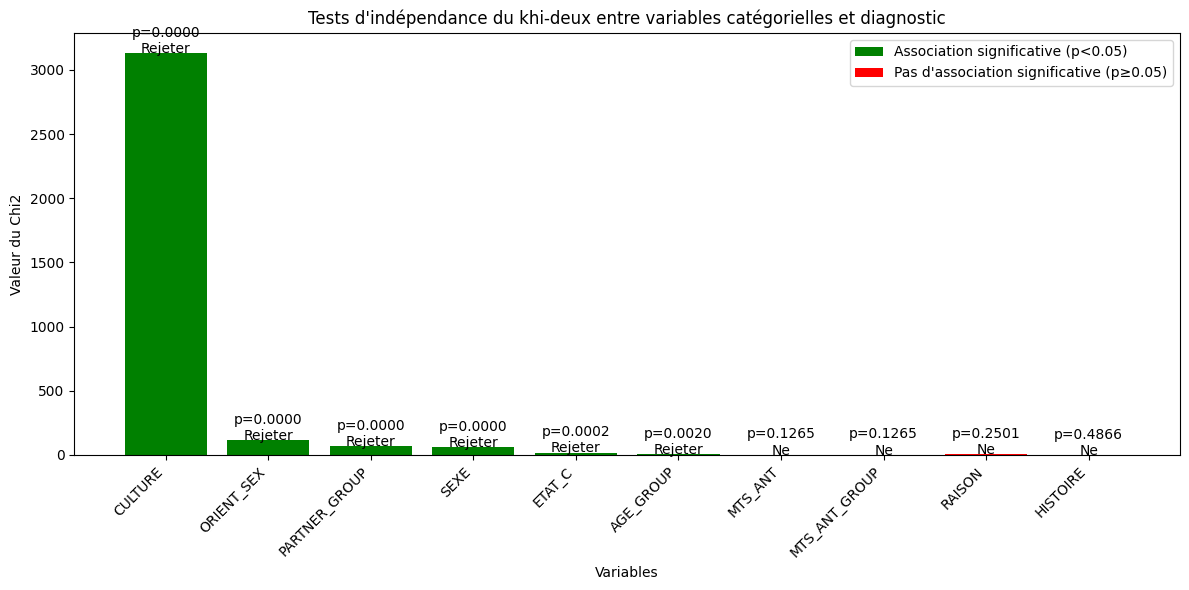

Résultats des tests d'indépendance du khi-deux :
H0 : La variable et le diagnostic sont indépendants
H1 : La variable et le diagnostic ne sont pas indépendants

         Variable         Chi2       p-value  ddl                    Décision
7        CULTURE  3132.000000  0.000000e+00    6         Rejeter H0 (p<0.05)
8     ORIENT_SEX   116.519139  4.991032e-26    2         Rejeter H0 (p<0.05)
9  PARTNER_GROUP    68.428188  1.315831e-16    1         Rejeter H0 (p<0.05)
0           SEXE    59.337118  1.328470e-14    1         Rejeter H0 (p<0.05)
1         ETAT_C    19.199642  2.486038e-04    3         Rejeter H0 (p<0.05)
2      AGE_GROUP     9.584482  1.962288e-03    1         Rejeter H0 (p<0.05)
3        MTS_ANT     2.335407  1.264619e-01    1  Ne pas rejeter H0 (p≥0.05)
4  MTS_ANT_GROUP     2.335407  1.264619e-01    1  Ne pas rejeter H0 (p≥0.05)
5         RAISON     5.384069  2.501094e-01    4  Ne pas rejeter H0 (p≥0.05)
6       HISTOIRE     0.483976  4.866269e-01    1  Ne pas rejeter H0 

In [73]:
from scipy.stats import chi2_contingency # Import chi2_contingency from scipy.stats


def chi2_test_with_hypotheses(df_gono, categorical_vars, target='DIAGN', alpha=0.05):
    """
    Réalise le test du khi-deux pour tester l'indépendance entre chaque variable catégorielle et la variable cible.

    Hypothèses:
    H0 : La variable catégorielle et le diagnostic sont indépendants
    H1 : La variable catégorielle et le diagnostic ne sont pas indépendants

    Si p-value < alpha, on rejette H0 en faveur de H1.
    """
    # Calculer chi2 et p-value pour chaque variable
    results = pd.DataFrame([
        {'Variable': var,
         'Chi2': chi2_contingency(pd.crosstab(df_gono
          [var], df_gono[target]))[0],
         'p-value': chi2_contingency(pd.crosstab(df_gono[var], df_gono[target]))[1],
         'ddl': chi2_contingency(pd.crosstab(df_gono[var], df_gono[target]))[2]}
        for var in categorical_vars
    ]).sort_values('p-value')

    # Ajouter la colonne de décision
    results['Décision'] = results['p-value'].apply(
        lambda p: f"Rejeter H0 (p<{alpha})" if p < alpha else f"Ne pas rejeter H0 (p≥{alpha})")

    # Visualiser les résultats
    plt.figure(figsize=(12, 6))
    bars = plt.bar(results['Variable'], results['Chi2'],
            color=['green' if p < alpha else 'red' for p in results['p-value']])

    # Ajouter les p-values et décisions
    for bar, p, decision in zip(bars, results['p-value'], results['Décision']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'p={p:.4f}\n{decision.split(" ")[0]}', ha='center')

    plt.title('Tests d\'indépendance du khi-deux entre variables catégorielles et diagnostic')
    plt.xlabel('Variables')
    plt.ylabel('Valeur du Chi2')
    plt.xticks(rotation=45, ha='right')
 # Ajouter une légende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label=f'Association significative (p<{alpha})'),
        Patch(facecolor='red', label=f'Pas d\'association significative (p≥{alpha})')
    ]
    plt.legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()

    # Afficher un tableau récapitulatif
    print("Résultats des tests d'indépendance du khi-deux :")
    print("H0 : La variable et le diagnostic sont indépendants")
    print("H1 : La variable et le diagnostic ne sont pas indépendants")
    print("\n", results)

    # Afficher les variables significativement associées au diagnostic
    sig_vars = results[results['p-value'] < alpha]['Variable'].tolist()
    print(f"\nVariables significativement associées au diagnostic (rejet de H0): {sig_vars}")

    return results

# Variables catégorielles à tester
categorical_vars = ['SEXE', 'ETAT_C', 'AGE_GROUP', 'MTS_ANT', 'MTS_ANT_GROUP',
                   'RAISON', 'HISTOIRE', 'CULTURE','ORIENT_SEX','PARTNER_GROUP']

# Exécuter le test avec les hypothèses clairement formulées
results = chi2_test_with_hypotheses(df_gono, categorical_vars)

MODELISATION PAR UNE REGRESSION LOGISTIQUE

Encodage des variables catégorielles

In [74]:
# Exclure 'ID'
df_gono_sans_id = df_gono.drop(columns=['ID', 'CULTURE'])  #
# Sélectionner les colonnes de type 'object'
categorical_columns = df_gono_sans_id.select_dtypes(include=['object']).columns

# Ajouter les colonnes numériques (par exemple, les variables ordinales codées en 1, 2, 3, etc.)
numeric_columns = df_gono_sans_id.select_dtypes(include=['int', 'float']).columns

# Combiner les deux
all_categorical_columns = list(categorical_columns) + list(numeric_columns)

# Afficher les colonnes sélectionnées
print("Colonnes catégorielles et ordinales sélectionnées :")
all_categorical_columns


Colonnes catégorielles et ordinales sélectionnées :


['AGE_GROUP',
 'MTS_ANT_GROUP',
 'PARTNER_GROUP',
 'SEXE',
 'ETAT_C',
 'ORIENT_SEX',
 'MTS_ANT',
 'RAISON',
 'HISTOIRE',
 'DIAGN']

In [75]:
from sklearn.preprocessing import OneHotEncoder # Import the OneHotEncoder class

ohe=OneHotEncoder(sparse_output= False, drop='first')
ohe_resultat=ohe.fit_transform(df_gono[all_categorical_columns])
encodage_gono = pd.DataFrame(ohe_resultat, columns=ohe.get_feature_names_out(all_categorical_columns))
encodage_gono = encodage_gono.astype(int)
encodage_gono.head()

,AGE_GROUP_>=30,MTS_ANT_GROUP_Pas encore,PARTNER_GROUP_Très actifs,SEXE_2,ETAT_C_2.0,ETAT_C_3.0,ETAT_C_4.0,ORIENT_SEX_2.0,ORIENT_SEX_3.0,MTS_ANT_2,RAISON_2.0,RAISON_3.0,RAISON_4.0,RAISON_5.0,HISTOIRE_1.0,DIAGN_1.0
0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [76]:

# Rename columns to uppercase
encodage_gono.columns = [col.upper() for col in encodage_gono.columns]


In [77]:
gono= encodage_gono
gono.head()


,AGE_GROUP_>=30,MTS_ANT_GROUP_PAS ENCORE,PARTNER_GROUP_TRÈS ACTIFS,SEXE_2,ETAT_C_2.0,ETAT_C_3.0,ETAT_C_4.0,ORIENT_SEX_2.0,ORIENT_SEX_3.0,MTS_ANT_2,RAISON_2.0,RAISON_3.0,RAISON_4.0,RAISON_5.0,HISTOIRE_1.0,DIAGN_1.0
0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


Cette fonction permet de voir la fréquence des groupes catégoriels dans la base.

In [78]:
print("Répartition des classes dans l'ensemble initial :")
print(gono['DIAGN_1.0'].value_counts().to_frame('Effectif').assign(**{'Pourcentage (%)': lambda x: x['Effectif'] / len(gono) * 100}))

Répartition des classes dans l'ensemble initial :
           Effectif  Pourcentage (%)
DIAGN_1.0                           
0              2368        75.606641
1               764        24.393359


In [ ]:
def frequence(df):
  for v in df.columns:
    print(df[v].value_counts())
    print('----')

frequence(gono)


AGE_GROUP_>=30
0    1949
1    1183
Name: count, dtype: int64
----
MTS_ANT_GROUP_PAS ENCORE
0    1624
1    1508
Name: count, dtype: int64
----
PARTNER_GROUP_TRÈS ACTIFS
0    2505
1     627
Name: count, dtype: int64
----
SEXE_2
0    2418
1     714
Name: count, dtype: int64
----
ETAT_C_2.0
0    2908
1     224
Name: count, dtype: int64
----
ETAT_C_3.0
0    2965
1     167
Name: count, dtype: int64
----
ETAT_C_4.0
0    3125
1       7
Name: count, dtype: int64
----
ORIENT_SEX_2.0
0    1815
1    1317
Name: count, dtype: int64
----
ORIENT_SEX_3.0
0    2875
1     257
Name: count, dtype: int64
----
MTS_ANT_2
1    1624
0    1508
Name: count, dtype: int64
----
RAISON_2.0
0    2566
1     566
Name: count, dtype: int64
----
RAISON_3.0
0    2122
1    1010
Name: count, dtype: int64
----
RAISON_4.0
0    3068
1      64
Name: count, dtype: int64
----
RAISON_5.0
0    3094
1      38
Name: count, dtype: int64
----
HISTOIRE_1.0
0    2566
1     566
Name: count, dtype: int64
----
DIAGN_1.0
0    2368
1     764
Na

On observe ici que les 0 sont majoritaires (on plus de poids que les 1) dans presque toutes variables, cela peut impacter la performance de la prédiction.

Déclaration de la variable dépendante et explicative.

---



On rétire MTS_ANT car avec ectte variable on peut estimer la variable MTS_ANT_Groupe, si on le garde il y aura une multicolinéarité entre les variables.
On rétire également la variable culture car on ne voit pas son importance dans notre modèle.

In [79]:
X = gono.drop(columns= ['DIAGN_1.0','MTS_ANT_2'])
y = gono['DIAGN_1.0']

In [ ]:
X.head()

,AGE_GROUP_>=30,MTS_ANT_GROUP_PAS ENCORE,PARTNER_GROUP_TRÈS ACTIFS,SEXE_2,ETAT_C_2.0,ETAT_C_3.0,ETAT_C_4.0,ORIENT_SEX_2.0,ORIENT_SEX_3.0,RAISON_2.0,RAISON_3.0,RAISON_4.0,RAISON_5.0,HISTOIRE_1.0
0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Modélisation de la régression logistique

Le VIF permet de vérifier s'il y a de la multicolinéarité entre les variables.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                     Variable       VIF
0              AGE_GROUP_>=30  1.556873
1    MTS_ANT_GROUP_PAS ENCORE  1.866298
2   PARTNER_GROUP_TRÈS ACTIFS  1.214462
3                      SEXE_2  1.891490
4                  ETAT_C_2.0  1.234815
5                  ETAT_C_3.0  1.184231
6                  ETAT_C_4.0  1.013865
7              ORIENT_SEX_2.0  2.420621
8              ORIENT_SEX_3.0  1.120403
9                  RAISON_2.0       inf
10                 RAISON_3.0  1.479381
11                 RAISON_4.0  1.028140
12                 RAISON_5.0  1.022525
13               HISTOIRE_1.0       inf


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Il y a les variables Histoire et raison qui ont VIF infini, ce qui veut dire qu'il y a une forte correlation avec les autres variables donc on les rétire.

In [80]:
X1=X.drop(columns=['RAISON_2.0'])

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
vif_data = pd.DataFrame()
vif_data["Variable"] = X1.columns
vif_data["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]

print(vif_data)

                     Variable       VIF
0              AGE_GROUP_>=30  1.556873
1    MTS_ANT_GROUP_PAS ENCORE  1.866298
2   PARTNER_GROUP_TRÈS ACTIFS  1.214462
3                      SEXE_2  1.891490
4                  ETAT_C_2.0  1.234815
5                  ETAT_C_3.0  1.184231
6                  ETAT_C_4.0  1.013865
7              ORIENT_SEX_2.0  2.420621
8              ORIENT_SEX_3.0  1.120403
9                  RAISON_3.0  1.479381
10                 RAISON_4.0  1.028140
11                 RAISON_5.0  1.022525
12               HISTOIRE_1.0  1.301004


Division en ensemble d'entraînement et de test

In [81]:


# Première étape : séparer le jeu de données en entraînement (60%) et temporaire (40%)
X_train, X_temp, y_train, y_temp = train_test_split( X1, y,test_size=0.4,random_state=42,stratify=y)  # Optionnel : assure une répartition similaire des classes

# Deuxième étape : séparer le jeu temporaire en validation (20%) et test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp)  # Optionnel si vous voulez la même proportion de classes dans val et test


print("Entraînement :", X_train.shape, y_train.shape)
print("Validation  :", X_val.shape,   y_val.shape)
print("Test        :", X_test.shape,  y_test.shape)


Entraînement : (1879, 13) (1879,)
Validation  : (626, 13) (626,)
Test        : (627, 13) (627,)


In [82]:

model = LogisticRegression(max_iter=1000, class_weight='balanced')

# 4) Entraîner le modèle sur le dataset d'entraînement
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [83]:

val_pred = model.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
print("----- Validation Set -----")
print("Accuracy :", val_acc)
print("Confusion Matrix :\n", confusion_matrix(y_val, val_pred))
print("Classification Report :\n", classification_report(y_val, val_pred))

test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print("----- Test Set -----")
print("Accuracy :", test_acc)
print("Confusion Matrix :\n", confusion_matrix(y_test, test_pred))
print("Classification Report :\n", classification_report(y_test, test_pred))

----- Validation Set -----
Accuracy : 0.6086261980830671
Confusion Matrix :
 [[287 186]
 [ 59  94]]
Classification Report :
               precision    recall  f1-score   support

           0       0.83      0.61      0.70       473
           1       0.34      0.61      0.43       153

    accuracy                           0.61       626
   macro avg       0.58      0.61      0.57       626
weighted avg       0.71      0.61      0.64       626

----- Test Set -----
Accuracy : 0.6220095693779905
Confusion Matrix :
 [[305 169]
 [ 68  85]]
Classification Report :
               precision    recall  f1-score   support

           0       0.82      0.64      0.72       474
           1       0.33      0.56      0.42       153

    accuracy                           0.62       627
   macro avg       0.58      0.60      0.57       627
weighted avg       0.70      0.62      0.65       627



In [84]:
# prompt: Affiche les coefficients et les p_value des variables selectionnées pour ce modèle

# Add constant to the predictor variables
X1_with_constant = sm.add_constant(X1)

# Fit the logistic regression model
model_sm = sm.Logit(y, X1_with_constant).fit()

# Print the model summary
print(model_sm.summary())


Optimization terminated successfully.
         Current function value: 0.525802
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              DIAGN_1.0   No. Observations:                 3132
Model:                          Logit   Df Residuals:                     3118
Method:                           MLE   Df Model:                           13
Date:                Tue, 08 Apr 2025   Pseudo R-squ.:                 0.05358
Time:                        16:25:20   Log-Likelihood:                -1646.8
converged:                       True   LL-Null:                       -1740.1
Covariance Type:            nonrobust   LLR p-value:                 8.053e-33
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.7695      0.096     -8.049      0.000      -0.

On a un accuracy de 0,75 ce qui signifie que le modèle a correctement prédit 75% des observations sur l'ensemble de données.Ce métrique n'est pas un très bon indicateur de la performance d'un modèle, en plus dans notre modèle il y a un deséquilibre entre les classes ce qui peut expliquer la valeur haute de l'accuracy.

On vérifie la performaance du modèle avec d'autres métriques comme la précision, F1-score et AUC-ROC.

In [90]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul des métriques
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], multi_class='ovr', average='weighted')

# Afficher les résultats
print("Précision : ", precision)
print("Rappel : ", recall)
print("F1-Score : ", f1)
print("AUC-ROC : ", auc_roc)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", cm)


Précision :  0.6998212420556092
Rappel :  0.6220095693779905
F1-Score :  0.6463734823891413
AUC-ROC :  0.6473759686715757
Matrice de confusion :
 [[305 169]
 [ 68  85]]


In [91]:
# Afficher les résultats du modèle
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.64      0.72       474
           1       0.33      0.56      0.42       153

    accuracy                           0.62       627
   macro avg       0.58      0.60      0.57       627
weighted avg       0.70      0.62      0.65       627

Confusion Matrix:
 [[305 169]
 [ 68  85]]


In [93]:
# Extraire les coefficients (log-odds) du modèle
coef = model_sm.params

# Calculer les odds ratios (exponentiation des coefficients)
odds_ratios = np.exp(coef)

# Obtenir l'intervalle de confiance (IC à 95 %) pour chaque coefficient
conf = model_sm.conf_int()
conf_odds = np.exp(conf)

# Créer un DataFrame récapitulatif contenant Coefficient, Odds Ratio, IC et p-value
results_table = pd.DataFrame({
    "Coefficient": coef.round(2),
    "Odds Ratio": odds_ratios.round(2),
    "IC Lower": conf_odds[0].round(2),
    "IC Upper": conf_odds[1].round(2),
    "p-value": model_sm.pvalues.round(3)
})

# Ajout d'une colonne indiquant la significativité (par exemple, "Significatif" si p < 0.05)
results_table['Significatif'] = results_table['p-value'] < 0.05

print(results_table)

                           Coefficient  Odds Ratio  IC Lower  IC Upper  \
const                            -0.77        0.46      0.38      0.56   
AGE_GROUP_>=30                   -0.40        0.67      0.56      0.81   
MTS_ANT_GROUP_PAS ENCORE          0.07        1.08      0.90      1.28   
PARTNER_GROUP_TRÈS ACTIFS         0.55        1.73      1.41      2.11   
SEXE_2                           -0.46        0.63      0.48      0.84   
ETAT_C_2.0                       -0.25        0.78      0.51      1.19   
ETAT_C_3.0                        0.28        1.32      0.86      2.02   
ETAT_C_4.0                        0.28        1.32      0.16     11.15   
ORIENT_SEX_2.0                   -0.70        0.49      0.39      0.62   
ORIENT_SEX_3.0                   -0.69        0.50      0.36      0.70   
RAISON_3.0                       -0.01        0.99      0.81      1.20   
RAISON_4.0                       -0.41        0.66      0.34      1.30   
RAISON_5.0                       -0.65